# N Pendulum on a mover
This notebook contains a simple way to animate N pendulums on a moving mass

In [25]:
#Libraries for solving the ODE and handling the data
from scipy.integrate import solve_ivp
import pandas as pd
import numpy as np
#Libraries for the rendering
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, clear_output, HTML

## Utilities

In [26]:
# Map to convert any angle to the range 0-2pi
def map_to_2pi(alpha):
  k = np.floor(alpha/(2*np.pi)) #Number of complete rotations
  alpha = alpha-k*2*np.pi
  return alpha

# Plot the pendulum
def plot_trajectory(data_frames, t_span=None, color='g'):
  data_frames = (lambda x: x if type(x) is tuple else (x,))(data_frames)  #If the input is a single element make it a tuple, else, execute normally
  fig, ax = plt.subplots()
  max = []
  for df in data_frames:
    max.append(1.1*np.abs(df['y']).max()) #Find the maximum distance from the origin 
    
  fig.suptitle('Double pendulum')
      
  max = np.array(max).max() 
  
  ax.set_xlim(-max, max)
  ax.set_ylim(-max, max)
  ax.set_aspect('equal')
  ax.grid()
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  if t_span != None:
    ax.text(0.05,0.9, f't = {t_span[1]:.2f}', transform = ax.transAxes)
  
  for df in data_frames:
    if t_span != None:
      df = df[(df['t'] >= t_span[0]) & (df['t'] <= t_span[1])]
    
    ax.plot(df['x'], df['y'])
    ax.plot([0, df.iloc[-1][ 'x']], [0, df.iloc[-1][ 'y']], 'r-o')
  plt.show()

### A more complex function to animate using blitting

In [27]:
#Creation of the plot and the artists inside

def create_plot(data_frames, color='g'):
  fig, ax = plt.subplots()
  max = []
  for df in data_frames:
    max.append(1.1*np.abs(df['y']).max()) #Find the maximum distance from the origin 
    
  fig.suptitle('Double pendulum')      
  max = np.array(max).max() 
  
  ax.set_xlim(-max, max)
  ax.set_ylim(-max, max)
  ax.set_aspect('equal')
  ax.grid(':')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  time = ax.text(0.05,0.9,'', transform = ax.transAxes)
  #NB: both traces and markers are memorized as an array of arrays containing the single element
  traces = [ax.plot(0,0, linestyle = '-', alpha=0.5) for df in data_frames]
  markers = [ax.plot(0,0, c = trace[0].get_color(), linestyle = ':', marker = 'o') for trace in traces]
  plt.close('all')
  return fig, [traces, markers, time]



In [28]:
#Functions to plot, update the plot and animate it updating the artists inside

#Plots the figure by updating the objects inside
def plot_figure(data_frames, t_span=None):
  data_frames = (lambda x: x if type(x) is tuple else (x,))(data_frames)  #If the input is a single element make it a tuple, else, execute normally
  fig, artists = create_plot(data_frames)
  traces, markers, time = artists[0], artists[1], artists[2]    
  
  # reduce the dataframes to the time limits 
  if t_span != None:  
    time.set_text(f't = {t_span[1]:.2f}')
    data_restricted = [df[(df['t'] >= t_span[0]) & (df['t'] <= t_span[1])] for df in data_frames]
  else:
    data_restricted = data_frames

  #for all couples plot, df set the data of the plots
  for trace, df in zip(traces, data_restricted): trace[0].set_data(df['x'], df['y']) 
  for marker, df in zip(markers, data_restricted): marker[0].set_data([0, df.iloc[-1][ 'x']], [0, df.iloc[-1][ 'y']])   
  display(fig)

#Realtime animation 
def animate_RT(data_frames, time_step = 0.05, tail=2.5, t_span=None):  
  data_frames = (lambda x: x if type(x) is tuple else (x,))(data_frames)  
  fig, artists = create_plot(data_frames)
  
  if t_span == None:
    t_stop, t_start = data_frames[0].iloc[-1]['t'], data_frames[0].iloc[0]['t'] #Beginning and end of the animation
  else:
    t_start, t_stop = t_span[0], t_span[1]
  t = t_start
  
  while t<=t_stop:
    update(t, tail, data_frames, artists)
    display(fig)
    clear_output(wait=True) 
    t = t + time_step

#Update the frame of animation
def update(t, tail, data_frames, artists, t_step=None):
  #In RT animation t is the final time, in funcAnimation is the frame of the image 
  # so I scale it back to the time
  if t_step != None:
    t = t*t_step
  traces, markers, time = artists[0], artists[1], artists[2]    
  time.set_text(f't = {t:.2f}')
  data_restricted = [df[(df['t'] >= t-tail) & (df['t'] <= t)] for df in data_frames]  
  for trace, df in zip(traces, data_restricted): trace[0].set_data(df['x'], df['y']) 
  for marker, df in zip(markers, data_restricted): marker[0].set_data([0, df.iloc[-1][ 'x']], [0, df.iloc[-1][ 'y']])   

#HTML animation usin FuncAnimation
def animate_HTML(data_frames, duration=5.0, tail = 2.5, fps=15, t_span=None):
  data_frames = (lambda x: x if type(x) is tuple else (x,))(data_frames) 
  
  if t_span == None:
    t_stop, t_start = data_frames[0].iloc[-1]['t'], data_frames[0].iloc[0]['t'] #Beginning and end of the animation
  else:
    t_start, t_stop = t_span[0], t_span[1]
    
  fig, artists = create_plot(data_frames)
  n_frames = round(duration*fps)  #Total number of frames
  t_step = (t_stop-t_start)/n_frames  # Time step for frame
  ani = animation.FuncAnimation(fig, update, n_frames, fargs = (tail, data_frames, artists, t_step), interval = 1000.0/fps, blit=False)
  return ani

## Lagrangian of the pendulum
The simplest case of mover and pendulum has the mover described by its position $ x $, while the pendulum is described by $ x_P = x + r \sin \theta $, $ y_P = r \cos \theta $. The kinetic energy $ E_k = \frac{1}{2}M\dot x^2 + \frac{1}{2}mr^2 \dot x^2 + mr \dot x \dot \theta \cos \theta$ and potential $ U=mgr \cos \theta $. 
The Eulero-Lagrange equations are 
$$ \begin{pmatrix}  M+m & mr \cos \theta\\ mr \cos \theta & mr^2 \end{pmatrix}  \begin{pmatrix} \ddot x \\ \ddot \theta \end{pmatrix} - \begin{pmatrix}  mr \dot \theta \sin \theta \\ mgr \sin \theta \end{pmatrix} = 0 $$  
 
### N-pendulums case


The version with N pendulums with masses A,B,... , angles $ \alpha $, $ \beta $, .., and lenghts a,b,... gives the matrix
$$ \begin{pmatrix}  M+A+B+... & Aa \cos \alpha & Bb \cos \beta & ... \\ Aa\cos \alpha & Aa^2 & 0 & ... \\ Bb \cos \beta & 0 & Bb^2 & ... \\ ... & ... & ... & ... \end{pmatrix}  \begin{pmatrix} \ddot x \\ \ddot \alpha \\ \ddot \beta \\ ... \end{pmatrix} - \begin{pmatrix}  Aa \dot \alpha \sin \alpha + Bb \dot \beta \sin \beta + ... \\ gAa \sin \alpha \\ gBb \sin \beta \\ ... \end{pmatrix} = 0 $$ 

In [33]:
# dy/dt = f(t,y), with y = (x, alpha, dx, dalpha)

def ODE(t, y, M, A, a, g):
  x, alpha, d_x, d_alpha = y[0], y[1], y[2], y[3]
  #Staring the system of equations to solve for the accelerations
  MA = np.array([[M+A, A*a*np.cos(alpha)], [A*a*np.cos(alpha), A*a**2]])
  b = np.array([A*a*d_alpha*np.sin(alpha), g*A*a*np.sin(alpha)])
  dd = np.linalg.solve(MA,b)
  return (d_x, d_alpha, dd[0], dd[1])


def system_df(y0, t_span, g=9.81, M = 1.0, A = 1.0, a = 1.0, n_points=2000):  
  
  Y = solve_ivp(ODE, t_span=t_span, y0=y0 , method='RK45', args=(M,A, a, g), t_eval=np.linspace(t_span[0],t_span[1], n_points), rtol=1e-6)
  system_df = pd.DataFrame({'t':Y.t, 'x': Y.y[0] , 'alpha': map_to_2pi(Y.y[1]), 'v_x': Y.y[2], 'v_alpha': Y.y[3]})
  system_df['xp'] = system_df['x'] + a*np.sin(system_df['alpha'])
  system_df['yp'] = a*np.cos(system_df['alpha'])
  return system_df


a = system_df(y0=(0.0, 0.8*np.pi, 0.0, 0.0), t_span=(0, 25), g=9.81, A=1.0, M=10.0, a=2.0)


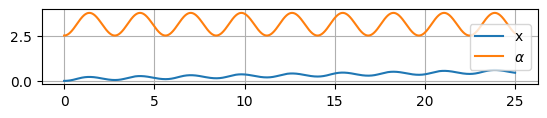

In [34]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.grid()
ax.plot(a['t'], a['x'], label ='x')
ax.plot(a['t'], a['alpha'], label =r'$\alpha$')
ax.legend()
